In [37]:
import llvmlite.binding as llvm
import copy
from random import choice
from typing import Optional, Union, Any, Set, List, Tuple, Dict, Collection
from llvmlite.binding import ValueRef
import matplotlib.pyplot as plt
import networkx as nx
import argparse

# TODO:
# 1. support global
# 2. why is there diff in matrix 1.in

class Graph:
    """
    The register interference graph.
    """

    def __init__(self):
        self._adjacency_list = {}

    def __copy__(self):
        cls = self.__class__
        new_graph = self.__new__(cls)
        new_graph._adjacency_list = copy.deepcopy(self._adjacency_list)
        return new_graph

    def add_edge(self, x, y):
        """
        Add an edge to the graph.
        The interference graph is undirected so add_edge('a', 'b') and add_edge('b', 'a') have the same effect.
        """
        # Add y to x
        x_list = self._adjacency_list.get(x, [])
        if y not in x_list:
            x_list.append(y)
        self._adjacency_list[x] = x_list

        # Add x to y
        y_list = self._adjacency_list.get(y, [])
        if x not in y_list:
            y_list.append(x)
        self._adjacency_list[y] = y_list

    def contains_edge(self, x, y):
        return y in self._adjacency_list.get(x, [])

    def remove_node(self, node):
        if node in self._adjacency_list:
            self._adjacency_list.pop(node)
        for key in self._adjacency_list.keys():
            if node in self._adjacency_list.get(key):
                self._adjacency_list.get(key).remove(node)

    def rename_node(self, from_label, to_label):
        from_list = self._adjacency_list.pop(from_label, [])
        to_list = self._adjacency_list.get(to_label, [])
        self._adjacency_list[to_label] = list(set(from_list + to_list))

        for key in self._adjacency_list.keys():
            self._adjacency_list[key] = list(set(
                [to_label if value ==
                    from_label else value for value in self._adjacency_list[key]]
            ))

    def neighbors(self, x):
        return self._adjacency_list.get(x, [])

    def plot(self, coloring, title):
        G = nx.Graph()

        # Sorting to get repeatable graphs
        nodes = sorted(self._adjacency_list.keys())
        ordered_coloring = [coloring.get(node, 'grey') for node in nodes]
        G.add_nodes_from(nodes)

        for key in self._adjacency_list.keys():
            for value in self._adjacency_list[key]:
                G.add_edge(key, value)

        plt.title(title)
        plt.size = (20, 20)
        # other layout available at https://networkx.org/documentation/stable/reference/drawing.html
        nx.draw(G, pos=nx.shell_layout(G), node_color=ordered_coloring,
                with_labels=True)
        plt.show()

    def all_nodes(self):
        return self._adjacency_list.keys()


def color_graph(g: Graph, regs: Collection[str], colors: List[str]) -> Optional[Dict[str, str]]:
    if len(regs) == 0:
        return {}

    node = next((node for node in regs if len(
        g.neighbors(node)) < len(colors)), None)
    if node is None:
        return None

    g_copy = copy.copy(g)
    g_copy.remove_node(node)
    coloring = color_graph(g_copy, [n for n in regs if n != node], colors)
    if coloring is None:
        return None

    neighbor_colors = [coloring[neighbor] for neighbor in g.neighbors(node)]
    coloring[node] = [
        color for color in colors if color not in neighbor_colors][0]

    return coloring


def save() -> List[str]:
    return [f"pushq %r{x}" for x in range(8, 16)]


def restore() -> List[str]:
    return [f"popq %r{x}" for x in range(8, 16)][::-1]


def codeGenForFunc(fn: ValueRef, showImg=True) -> List[str]:
    funcName = fn.name
    print("codeGenForFunc", funcName)

    ins: List[ValueRef] = []
    allocas: Dict[str, int] = {}
    useDef: Dict[int, List[Any]] = {}
    labelToIdx: Dict[str, int] = {}

    for b in fn.blocks:
        labelToIdx[b.name] = len(
            [_ for _ in ins if _.opcode not in ["alloca"]])  # TODO ensure this
        ins += [_ for _ in b.instructions]
    # if '' in labelToIdx.keys():
    labelToIdx.pop("")

    print(labelToIdx)

    idxToLabel = {value: key for key, value in labelToIdx.items()}

    # collect allocas and construct use-def chain
    idx = 0
    for i in ins:
        op = i.opcode
        if op == "alloca":
            # TODO spill also increase size
            # TODO not actually alloca for arg4+
            if str(i.type) == "i32*":
                # allocas[i.name] = 4
                allocas[i.name] = 8
            else:
                allocas[i.name] = 8
            idx -= 1
        elif op == "store":
            use = []
            for j in i.operands:
                if j.name != "" and j.name not in allocas:
                    use.append(j.name)
            useDef[idx] = [i, set(use), set()]
        elif op == "br":
            use = []
            for j in i.operands:
                if str(j.type) != "label":
                    if j.name != "" and j.name not in allocas:
                        use.append(j.name)
            useDef[idx] = [i, set(use), set()]
        elif op == "call":
            use = []
            defs = []
            if i.name != "":
                defs.append(i.name)
            for j in i.operands:
                isFnType = '(' in str(j.type) and ')' in str(j.type)
                if not isFnType and j.name != "" and j.name not in allocas:
                    use.append(j.name)
            useDef[idx] = [i, set(use), set(defs)]
        else:
            use = []
            defs = []
            if i.name != "":
                defs.append(i.name)
            for j in i.operands:
                if j.name != "" and j.name not in allocas:
                    use.append(j.name)
            useDef[idx] = [i, set(use), set(defs)]
        idx += 1

    # get succ
    for idx in useDef:
        if idx == len(useDef)-1:
            useDef[idx].insert(1, [])
            continue
        theI = useDef[idx][0]
        op = theI.opcode
        if op == "br":
            print(theI)
            labels: List[ValueRef] = [
                _ for _ in theI.operands if str(_.type) == "label"]
            useDef[idx].insert(1, [labelToIdx[_.name] for _ in labels])
        else:
            useDef[idx].insert(1, [idx+1])

    # print useDef
    for i in useDef:
        print(i, useDef[i][1:])

    # get out in
    theIn = [set() for _ in useDef]
    theOut = [set() for _ in useDef]
    theIn2 = [set() for _ in useDef]
    theOut2 = [set() for _ in useDef]

    init = 1

    def pretty(s: Set[str]):
        return "{" + ", ".join(s) + "}"

    def done():
        nonlocal init
        if init:
            init = 0
            return False
        for i in range(len(theIn)):
            if theIn[i] != theIn2[i] or theOut[i] != theOut2[i]:
                return False
        print("done")
        return True

    count = 0
    while not done():
        # for ff in range(9):
        count += 1
        theIn2 = copy.deepcopy(theIn)
        theOut2 = copy.deepcopy(theOut)
        # reverse
        for idx in range(len(useDef)-1, -1, -1):
            theIn[idx] = useDef[idx][2] | (theOut[idx] - useDef[idx][3])
            theOut[idx] = set()
            for succ in useDef[idx][1]:
                theOut[idx] |= theIn[succ]
    print("count", count)

    # print def use in out
    for i in range(len(theIn)):
        print(i, pretty(useDef[i][3]), pretty(useDef[i][2]),
              "|", pretty(theIn[i]), pretty(theOut[i]))

    print(allocas)
    local = 8 * len(allocas)
    print(local)

    allTemp = set.union(*([useDef[idx][2]
                        for idx in useDef] + [useDef[idx][3] for idx in useDef]))
    print(allTemp)

    def build_graph() -> Graph:
        g = Graph()
        # for t in allTemp:
        #     print("add", t)
        #     g.add_edge(t, t)
        for idx in useDef:
            outs = theOut[idx]
            defs = useDef[idx][3]
            for aDef in defs:
                for aOut in outs:
                    if aDef != aOut:
                        print("add", aDef, aOut)
                        g.add_edge(aDef, aOut)
        return g

    g = build_graph()
    colors = [i for i in range(8)]
    coloring = color_graph(g, list(allTemp), colors)
    print("coloring", coloring)
    print("single nodes:", set(allTemp) - set(g.all_nodes()))
    print("color needed:", len(set(coloring.values())))
    if showImg:
        g.plot(coloring, f"{funcName}\nInterference Graph")
    # get depth in the stack
    depth: Dict[str, int] = {}
    for k, v in allocas.items():
        sum = 0
        for k2, v2 in allocas.items():
            sum += v2
            if k == k2:
                break
        depth[k] = sum
    print("depth", depth)

    # to real register
    def toR(reg: str | ValueRef, deRefer=False) -> str:
        if reg.name != '':
            reg = reg.name
        else:
            reg = str(reg)
        # now: "i32 0" / "t99"
        print("toR", reg)  # debug
        if 'i32' in reg or 'i64' in reg:
            _, n = reg.split(' ')
            if n=='null':
                return '$0'
            return f"${n}"
        elif '.arg' in reg:
            X, n = reg.split('.arg')
            n = int(n)
            if n == 0:
                return "%rdi"
            elif n == 1:
                return "%rsi"
            elif n == 2:
                return "%rdx"
            elif n == 3:
                return "%rcx"
            elif n >= 4:
                # update depth
                # ! assert X.argN => (X)
                # ra, rbp at 0, 8
                depth[X] = -((n-4)*8+16)
                return f'{-depth[X]}(%rbp)'
        elif deRefer and 'local_' in reg:
            return f'{-depth[reg]}(%rbp)'
        if deRefer:
            return f'(%r{coloring[reg]+8})'
        return f"%r{coloring[reg]+8}"

    asm: List[str] = []
    asm += [f"\t.globl {funcName}"]
    asm += [f"\t{funcName}:"]
    asm += [f"pushq %rbp"]
    asm += [f"movq %rsp, %rbp"]
    asm += [f"subq ${local}, %rsp"]
    asm += save()
    for idx in useDef:
        i: ValueRef = useDef[idx][0]
        print(">", i)
        op = i.opcode
        regs = [_ for _ in i.operands]
        cmds = []
        # insert label
        label = idxToLabel.get(idx, None)
        if label != None:
            asm += [f'\t{label}:']
        if op == "add":
            rs1 = toR(regs[0])
            rs2 = toR(regs[1])
            rd = toR(i)
            # TODO check for other cases!
            # do not overwrite rs2
            if rd == rs2:
                rs1, rs2 = rs2, rs1
            cmd1 = f"movq {rs1}, {rd}"
            cmd2 = f"addq {rs2}, {rd}"
            cmds = [cmd1, cmd2]
        elif op == "sub":
            rs1 = toR(regs[0])
            rs2 = toR(regs[1])
            rd = toR(i)
            toProtect = []
            insert = []
            if rd == rs2:
                insert = [f"movq {rs2}, %rcx"]
                rs2 = "%rcx"
                toProtect += ['%rcx']
            cmds += [f"pushq {r}" for r in toProtect]
            cmds += insert
            cmds += [f"movq {rs1}, {rd}"]
            cmds += [f"subq {rs2}, {rd}"]
            cmds += [f"popq {r}" for r in toProtect][::-1]
        elif op == "or":
            rs1 = toR(regs[0])
            rs2 = toR(regs[1])
            rd = toR(i)
            # do not overwrite rs2
            if rd == rs2:
                rs1, rs2 = rs2, rs1
            cmd1 = f"movq {rs1}, {rd}"
            cmd2 = f"orq {rs2}, {rd}"
            cmds = [cmd1, cmd2]
        elif op == "and":
            rs1 = toR(regs[0])
            rs2 = toR(regs[1])
            rd = toR(i)
            # do not overwrite rs2
            if rd == rs2:
                rs1, rs2 = rs2, rs1
            cmd1 = f"movq {rs1}, {rd}"
            cmd2 = f"andq {rs2}, {rd}"
            cmds = [cmd1, cmd2]
        elif op == "mul":
            rs1 = toR(regs[0])
            rs2 = toR(regs[1])
            rd = toR(i)
            insert = []
            toProtect = ['%rax', '%rdx']
            # need to allocate a reg for const
            if '$' in rs2:
                insert = [f"movq {rs2}, %rcx"]
                rs2 = "%rcx"
                toProtect += ['%rcx']
            cmds += [f"pushq {r}" for r in toProtect]
            cmds += [f"movq {rs1}, %rax"]
            cmds += insert
            cmds += [f"imulq {rs2}"]
            cmds += [f"movq %rax, {rd}"]
            cmds += [f"popq {r}" for r in toProtect][::-1]
        elif op == "sdiv":
            rs1 = toR(regs[0])
            rs2 = toR(regs[1])
            rd = toR(i)
            insert = []
            toProtect = ['%rax', '%rdx']
            # need to allocate a reg for const
            if '$' in rs2:
                insert = [f"movq {rs2}, %rcx"]
                rs2 = "%rcx"
                toProtect += ['%rcx']
            cmds += [f"pushq {r}" for r in toProtect]
            cmds += [f"movq {rs1}, %rax"]
            cmds += [f"cqto"]
            cmds += insert
            cmds += [f"idivq {rs2}"]
            cmds += [f"movq %rax, {rd}"]
            cmds += [f"popq {r}" for r in toProtect][::-1]
        elif op == "srem":
            rs1 = toR(regs[0])
            rs2 = toR(regs[1])
            rd = toR(i)
            insert = []
            toProtect = ['%rax', '%rdx']
            # need to allocate a reg for const
            if '$' in rs2:
                insert = [f"movq {rs2}, %rcx"]
                rs2 = "%rcx"
                toProtect += ['%rcx']
            cmds += [f"pushq {r}" for r in toProtect]
            cmds += [f"movq {rs1}, %rax"]
            cmds += [f"cqto"]
            cmds += insert
            cmds += [f"idivq {rs2}"]
            cmds += [f"movq %rdx, {rd}"]
            cmds += [f"popq {r}" for r in toProtect][::-1]
        elif op == 'store':
            rs = toR(regs[0])
            rd = toR(regs[1], True)
            if '(%rbp)' in rs:
                # arg4+, in stack, no need to store
                cmds = []
            else:
                cmds = [f"movq {rs}, {rd}"]
        elif op == 'load':
            rd = toR(i)
            rs = toR(regs[0], True)
            cmd = f'movq {rs}, {rd}'
            cmds = [cmd]
        elif op == 'icmp':
            # slt, ...
            exactType = str(i).split('icmp ')[1].split()[0]
            # ! assert first label is always next
            toSet = {
                'eq': 'sete',
                'ne': 'setne',
                'slt': 'setl',
                'sle': 'setle',
                'sgt': 'setg',
                'sge': 'setge',
            }
            a = toR(regs[0])
            b = toR(regs[1])
            rd = toR(i)
            # this is "a-b"
            cmds += [f"pushq %rax"]
            cmds += [f"movq $0, %rax"]
            cmds += [f"cmpq {b}, {a}"]
            cmds += [f"{toSet[exactType]} %al"]
            cmds += [f"movq %rax, {rd}"]
            cmds += [f"popq %rax"]
        elif op == 'br':
            labels = []
            for j in regs:
                if str(j.type) == "label":
                    labels += [j.name]
            labels.reverse()  # the right order
            if len(labels) == 1 and labelToIdx.get(labels[0]) != idx+1:
                cmds = [f"jmp {labels[0]}"]
            elif len(labels) == 2:
                # asm += [f"\t{str(labels)}"]
                rs = toR(regs[0])
                cmds += [f"cmpq $0, {rs}"]
                cmds += [f"je {labels[1]}"]
        elif op == 'call':
            rd = toR(i) if i.name != '' else None
            fn = regs[-1].name + "@PLT"
            args = [toR(_) for _ in regs[:-1]]
            theMap = {
                0: "%rdi",
                1: "%rsi",
                2: "%rdx",
                3: "%rcx",
            }
            # args
            reversePush = []
            for x, arg in enumerate(args):
                if x < 4:
                    cmds += [f"movq {arg}, {theMap[x]}"]
                else:
                    reversePush += [f"pushq {arg}"]
            cmds += reversePush[::-1]
            cmds += [f"call {fn}"]
            if rd != None:
                cmds += [f"movq %rax, {rd}"]
        elif op == 'ret':
            if len(regs) != 0:
                res = toR(regs[0])
                cmds += [f"movq {res}, %rax"]
                cmds += [f"jmp {funcName}_end"]
        elif op == 'getelementptr':
            # TODO really no need to protect rax?
            rs1 = toR(regs[0])
            rs2 = toR(regs[1])
            if '$' in rs2:
                # alloca reg for const
                cmds += [f"movq {rs2}, %rax"]
                rs2 = "%rax"
            rd = toR(i)
            cmds += [f"leaq ({rs1},{rs2},{8}), {rd}"]
        elif op == 'bitcast':
            rs = toR(regs[0])
            rd = toR(i)
            cmd = f"movq {rs}, {rd}"
            cmds = [cmd]
        else:
            cmds = ["!!!TODO!!!"]
        asm += [f'  #{str(i)}']
        asm += cmds
        print("  -", cmds)

    asm += [f"\t{funcName}_end:"]
    asm += restore()
    asm += [f"movq %rbp, %rsp"]
    asm += [f"popq %rbp"]
    asm += [f"retq"]

    print("-- ASM: --")
    print("\n".join(asm))

    return asm


def codeGen(fileName: str, showImg=True) -> List[List[str]]:
    llvm.initialize()
    ir = open(fileName).read()
    # the ModuleRef
    mod = llvm.parse_assembly(ir)
    mod.verify()
    print(mod.triple)
    asms = []
    for fn in mod.functions:
        if fn.is_declaration:
            continue
        asm = codeGenForFunc(fn, showImg)
        asms.append(asm)
    # llvm.shutdown()
    return asms


def ll2asm(inFile, outFile, showImg=True):
    asms = codeGen(inFile, showImg)
    flat = '\t.text\n'
    flat += '\n'.join(['\n'.join(x + ['']) for x in asms])
    with open(outFile, 'w') as f:
        f.write(flat)

x86_64-pc-linux-gnu
codeGenForFunc main_getInt
{'for.cond0.3': 7, 'for.body0.5': 15, 'if.body1.16': 19, 'if.end1.18': 23, 'for.post0.4': 26, 'for.end0.6': 27, 'for.cond2.25': 28, 'for.body2.27': 36, 'for.post2.26': 47, 'for.end2.28': 48}
  br label %for.cond0.3
  br i1 %t7, label %for.body0.5, label %for.end0.6
  br i1 %t19, label %if.body1.16, label %if.end1.18
  br label %if.end1.18
  br label %for.post0.4
  br label %for.cond0.3
  br label %for.cond2.25
  br i1 %t29, label %for.body2.27, label %for.end2.28
  br label %for.post2.26
  br label %for.cond2.25
0 [[1], set(), {'t0'}]
1 [[2], {'t0'}, set()]
2 [[3], set(), {'t1'}]
3 [[4], {'t1'}, set()]
4 [[5], set(), {'t2'}]
5 [[6], {'t2'}, set()]
6 [[7], set(), set()]
7 [[8], set(), {'t9'}]
8 [[9], set(), {'t10'}]
9 [[10], {'t10', 't9'}, {'t8'}]
10 [[11], set(), {'t12'}]
11 [[12], set(), {'t13'}]
12 [[13], {'t13', 't12'}, {'t11'}]
13 [[14], {'t8', 't11'}, {'t7'}]
14 [[27, 15], {'t7'}, set()]
15 [[16], set(), {'t20'}]
16 [[17], set(), {'t2

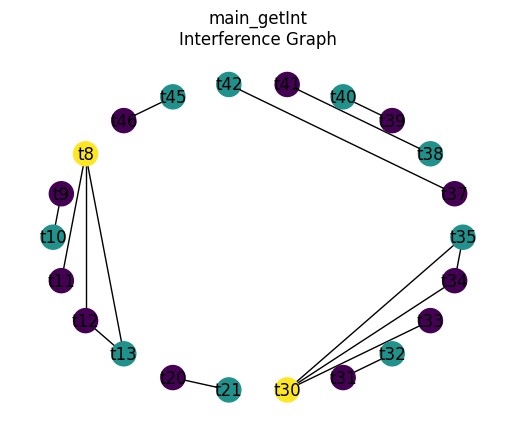

depth {'local_sign.0': 8, 'local_n.1': 16, 'local_c.2': 24}
>   %t0 = add i64 0, 1
toR i64 0
toR i64 1
toR t0
  - ['movq $0, %r8', 'addq $1, %r8']
>   store i64 %t0, i64* %local_sign.0, align 4
toR t0
toR local_sign.0
  - ['movq %r8, -8(%rbp)']
>   %t1 = add i64 0, 0
toR i64 0
toR i64 0
toR t1
  - ['movq $0, %r8', 'addq $0, %r8']
>   store i64 %t1, i64* %local_n.1, align 4
toR t1
toR local_n.1
  - ['movq %r8, -16(%rbp)']
>   %t2 = call i64 @getchar()
toR t2
  - ['call getchar@PLT', 'movq %rax, %r8']
>   store i64 %t2, i64* %local_c.2, align 4
toR t2
toR local_c.2
  - ['movq %r8, -24(%rbp)']
>   br label %for.cond0.3
  - []
>   %t9 = load i64, i64* %local_c.2, align 4
toR t9
toR local_c.2
  - ['movq -24(%rbp), %r8']
>   %t10 = add i64 0, 48
toR i64 0
toR i64 48
toR t10
  - ['movq $0, %r9', 'addq $48, %r9']
>   %t8 = icmp slt i64 %t9, %t10
toR t9
toR t10
toR t8
  - ['pushq %rax', 'movq $0, %rax', 'cmpq %r9, %r8', 'setl %al', 'movq %rax, %r10', 'popq %rax']
>   %t12 = load i64, i64* %loca

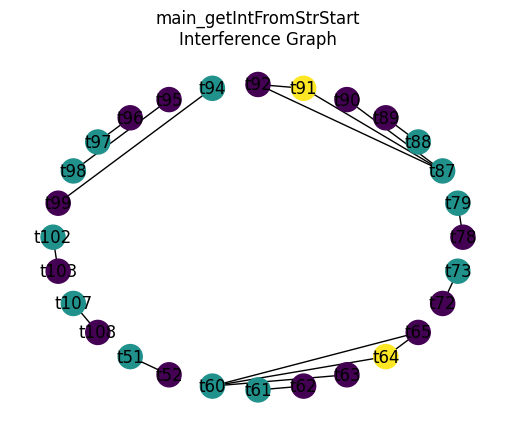

depth {'local_s.3': 8, 'local_sign.4': 16, 'local_n.5': 24, 'local_i.6': 32, 'local_c.7': 40}
>   store i64* %local_s.3.arg0, i64** %local_s.3, align 8
toR local_s.3.arg0
toR local_s.3
  - ['movq %rdi, -8(%rbp)']
>   %t48 = add i64 0, 1
toR i64 0
toR i64 1
toR t48
  - ['movq $0, %r8', 'addq $1, %r8']
>   store i64 %t48, i64* %local_sign.4, align 4
toR t48
toR local_sign.4
  - ['movq %r8, -16(%rbp)']
>   %t49 = add i64 0, 0
toR i64 0
toR i64 0
toR t49
  - ['movq $0, %r8', 'addq $0, %r8']
>   store i64 %t49, i64* %local_n.5, align 4
toR t49
toR local_n.5
  - ['movq %r8, -24(%rbp)']
>   %t50 = add i64 0, 0
toR i64 0
toR i64 0
toR t50
  - ['movq $0, %r8', 'addq $0, %r8']
>   store i64 %t50, i64* %local_i.6, align 4
toR t50
toR local_i.6
  - ['movq %r8, -32(%rbp)']
>   %t51 = load i64, i64* %local_i.6, align 4
toR t51
toR local_i.6
  - ['movq -32(%rbp), %r9']
>   %t52 = load i64*, i64** %local_s.3, align 4
toR t52
toR local_s.3
  - ['movq -8(%rbp), %r8']
>   %t53 = getelementptr inbounds i6

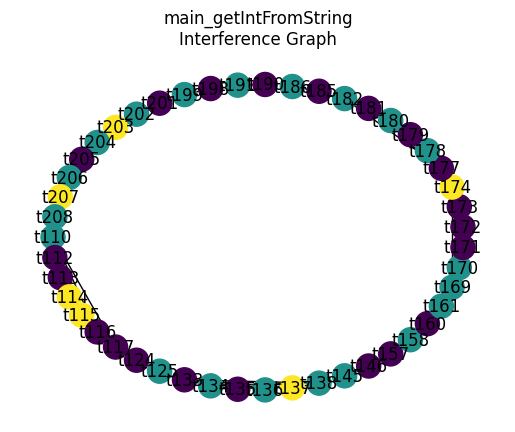

depth {'local_s.8': 8, 'local_x.9': 16, 'local_ret.10': 24, 'local_total.11': 32, 'local_found.12': 40, 'local_sign.13': 48, 'local_n.14': 56, 'local_i.15': 64, 'local_c.16': 72}
>   store i64* %local_s.8.arg0, i64** %local_s.8, align 8
toR local_s.8.arg0
toR local_s.8
  - ['movq %rdi, -8(%rbp)']
>   store i64 %local_x.9.arg1, i64* %local_x.9, align 4
toR local_x.9.arg1
toR local_x.9
  - ['movq %rsi, -16(%rbp)']
>   %t111 = call noalias i8* @malloc(i64 16)
toR t111
toR i64 16
  - ['movq $16, %rdi', 'call malloc@PLT', 'movq %rax, %r8']
>   %t110 = bitcast i8* %t111 to i64*
toR t111
toR t110
  - ['movq %r8, %r9']
>   %t113 = add i64 0, 1
toR i64 0
toR i64 1
toR t113
  - ['movq $0, %r8', 'addq $1, %r8']
>   %t112 = sub i64 0, %t113
toR i64 0
toR t113
toR t112
  - ['pushq %rcx', 'movq %r8, %rcx', 'movq $0, %r8', 'subq %rcx, %r8', 'popq %rcx']
>   %t114 = getelementptr inbounds i64, i64* %t110, i64 0
toR t110
toR i64 0
toR t114
  - ['movq $0, %rax', 'leaq (%r9,%rax,8), %r10']
>   store i64 

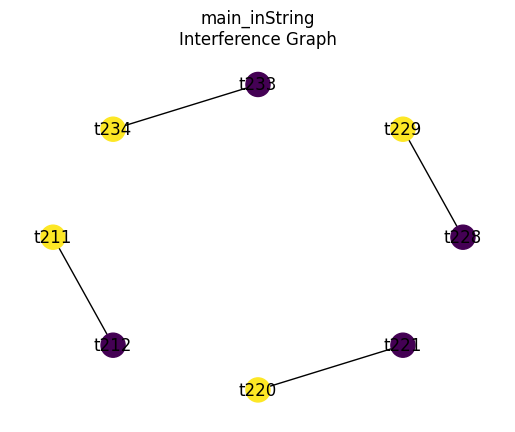

depth {'local_c.17': 8, 'local_s.18': 16, 'local_idx.19': 24, 'local_cur.20': 32}
>   store i64 %local_c.17.arg0, i64* %local_c.17, align 4
toR local_c.17.arg0
toR local_c.17
  - ['movq %rdi, -8(%rbp)']
>   store i64* %local_s.18.arg1, i64** %local_s.18, align 8
toR local_s.18.arg1
toR local_s.18
  - ['movq %rsi, -16(%rbp)']
>   %t210 = add i64 0, 0
toR i64 0
toR i64 0
toR t210
  - ['movq $0, %r8', 'addq $0, %r8']
>   store i64 %t210, i64* %local_idx.19, align 4
toR t210
toR local_idx.19
  - ['movq %r8, -24(%rbp)']
>   %t211 = load i64, i64* %local_idx.19, align 4
toR t211
toR local_idx.19
  - ['movq -24(%rbp), %r9']
>   %t212 = load i64*, i64** %local_s.18, align 4
toR t212
toR local_s.18
  - ['movq -16(%rbp), %r8']
>   %t213 = getelementptr inbounds i64, i64* %t212, i64 %t211
toR t212
toR t211
toR t213
  - ['leaq (%r8,%r9,8), %r8']
>   %t214 = load i64, i64* %t213, align 4
toR t214
toR t213
  - ['movq (%r8), %r8']
>   store i64 %t214, i64* %local_cur.20, align 4
toR t214
toR local_cu

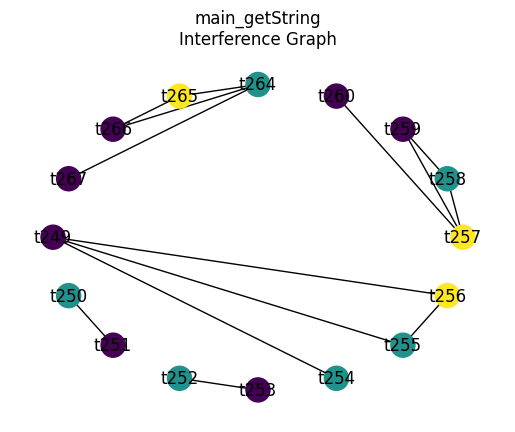

depth {'local_maxLen.21': 8, 'local_stop.22': 16, 'local_s.23': 24, 'local_i.24': 32, 'local_c.25': 40}
>   store i64 %local_maxLen.21.arg0, i64* %local_maxLen.21, align 4
toR local_maxLen.21.arg0
toR local_maxLen.21
  - ['movq %rdi, -8(%rbp)']
>   store i64* %local_stop.22.arg1, i64** %local_stop.22, align 8
toR local_stop.22.arg1
toR local_stop.22
  - ['movq %rsi, -16(%rbp)']
>   %t238 = load i64, i64* %local_maxLen.21, align 4
toR t238
toR local_maxLen.21
  - ['movq -8(%rbp), %r8']
>   %t240 = mul i64 %t238, 8
toR t238
toR i64 8
toR t240
  - ['pushq %rax', 'pushq %rdx', 'pushq %rcx', 'movq %r8, %rax', 'movq $8, %rcx', 'imulq %rcx', 'movq %rax, %r8', 'popq %rcx', 'popq %rdx', 'popq %rax']
>   %t241 = call noalias i8* @malloc(i64 %t240)
toR t241
toR t240
  - ['movq %r8, %rdi', 'call malloc@PLT', 'movq %rax, %r8']
>   %t239 = bitcast i8* %t241 to i64*
toR t241
toR t239
  - ['movq %r8, %r8']
>   store i64* %t239, i64** %local_s.23, align 8
toR t239
toR local_s.23
  - ['movq %r8, -24(%rb

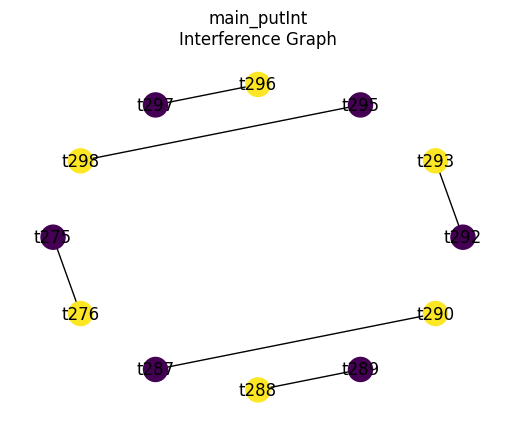

depth {'local_n.26': 8}
>   store i64 %local_n.26.arg0, i64* %local_n.26, align 4
toR local_n.26.arg0
toR local_n.26
  - ['movq %rdi, -8(%rbp)']
>   %t275 = load i64, i64* %local_n.26, align 4
toR t275
toR local_n.26
  - ['movq -8(%rbp), %r8']
>   %t276 = add i64 0, 0
toR i64 0
toR i64 0
toR t276
  - ['movq $0, %r9', 'addq $0, %r9']
>   %t274 = icmp slt i64 %t275, %t276
toR t275
toR t276
toR t274
  - ['pushq %rax', 'movq $0, %rax', 'cmpq %r9, %r8', 'setl %al', 'movq %rax, %r8', 'popq %rax']
>   br i1 %t274, label %if.body14.271, label %if.end14.273
toR t274
  - ['cmpq $0, %r8', 'je if.end14.273']
>   %t277 = add i64 0, 45
toR i64 0
toR i64 45
toR t277
  - ['movq $0, %r8', 'addq $45, %r8']
>   %t278 = call i64 @putchar(i64 %t277)
toR t278
toR t277
  - ['movq %r8, %rdi', 'call putchar@PLT', 'movq %rax, %r8']
>   %t280 = load i64, i64* %local_n.26, align 4
toR t280
toR local_n.26
  - ['movq -8(%rbp), %r8']
>   %t279 = sub i64 0, %t280
toR i64 0
toR t280
toR t279
  - ['pushq %rcx', 'movq %

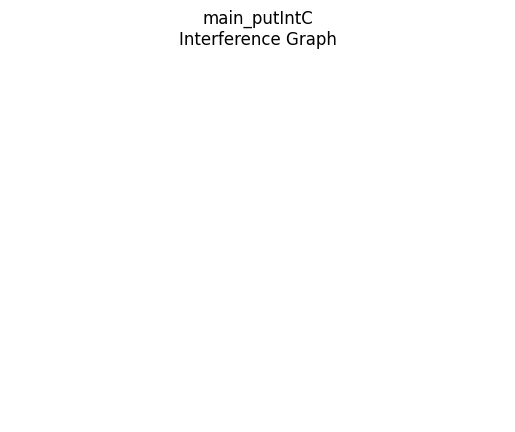

depth {'local_n.27': 8, 'local_c.28': 16}
>   store i64 %local_n.27.arg0, i64* %local_n.27, align 4
toR local_n.27.arg0
toR local_n.27
  - ['movq %rdi, -8(%rbp)']
>   store i64 %local_c.28.arg1, i64* %local_c.28, align 4
toR local_c.28.arg1
toR local_c.28
  - ['movq %rsi, -16(%rbp)']
>   %t300 = load i64, i64* %local_n.27, align 4
toR t300
toR local_n.27
  - ['movq -8(%rbp), %r8']
>   call void @main_putInt(i64 %t300)
toR t300
  - ['movq %r8, %rdi', 'call main_putInt@PLT']
>   %t301 = load i64, i64* %local_c.28, align 4
toR t301
toR local_c.28
  - ['movq -16(%rbp), %r8']
>   %t302 = call i64 @putchar(i64 %t301)
toR t302
toR t301
  - ['movq %r8, %rdi', 'call putchar@PLT', 'movq %rax, %r8']
>   ret void
  - []
-- ASM: --
	.globl main_putIntC
	main_putIntC:
pushq %rbp
movq %rsp, %rbp
subq $16, %rsp
pushq %r8
pushq %r9
pushq %r10
pushq %r11
pushq %r12
pushq %r13
pushq %r14
pushq %r15
  #  store i64 %local_n.27.arg0, i64* %local_n.27, align 4
movq %rdi, -8(%rbp)
  #  store i64 %local_c.28.a

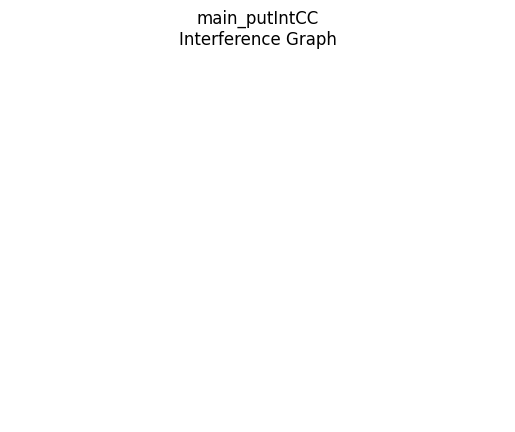

depth {'local_n.29': 8, 'local_c1.30': 16, 'local_c2.31': 24}
>   store i64 %local_n.29.arg0, i64* %local_n.29, align 4
toR local_n.29.arg0
toR local_n.29
  - ['movq %rdi, -8(%rbp)']
>   store i64 %local_c1.30.arg1, i64* %local_c1.30, align 4
toR local_c1.30.arg1
toR local_c1.30
  - ['movq %rsi, -16(%rbp)']
>   store i64 %local_c2.31.arg2, i64* %local_c2.31, align 4
toR local_c2.31.arg2
toR local_c2.31
  - ['movq %rdx, -24(%rbp)']
>   %t303 = load i64, i64* %local_n.29, align 4
toR t303
toR local_n.29
  - ['movq -8(%rbp), %r8']
>   call void @main_putInt(i64 %t303)
toR t303
  - ['movq %r8, %rdi', 'call main_putInt@PLT']
>   %t304 = load i64, i64* %local_c1.30, align 4
toR t304
toR local_c1.30
  - ['movq -16(%rbp), %r8']
>   %t305 = call i64 @putchar(i64 %t304)
toR t305
toR t304
  - ['movq %r8, %rdi', 'call putchar@PLT', 'movq %rax, %r8']
>   %t306 = load i64, i64* %local_c2.31, align 4
toR t306
toR local_c2.31
  - ['movq -24(%rbp), %r8']
>   %t307 = call i64 @putchar(i64 %t306)
toR t30

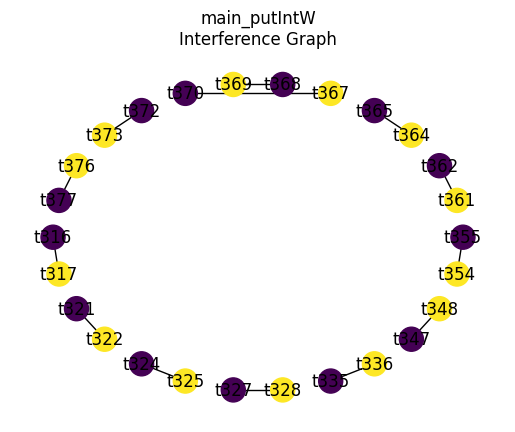

depth {'local_n.32': 8, 'local_width.33': 16, 'local_digits.34': 24, 'local_goDown.35': 32, 'local_goUp.36': 40, 'local_spaces.37': 48, 'local_i.38': 56, 'local_i.39': 64, 'local_d.40': 72}
>   store i64 %local_n.32.arg0, i64* %local_n.32, align 4
toR local_n.32.arg0
toR local_n.32
  - ['movq %rdi, -8(%rbp)']
>   store i64 %local_width.33.arg1, i64* %local_width.33, align 4
toR local_width.33.arg1
toR local_width.33
  - ['movq %rsi, -16(%rbp)']
>   %t308 = add i64 0, 0
toR i64 0
toR i64 0
toR t308
  - ['movq $0, %r8', 'addq $0, %r8']
>   store i64 %t308, i64* %local_digits.34, align 4
toR t308
toR local_digits.34
  - ['movq %r8, -24(%rbp)']
>   %t309 = load i64, i64* %local_n.32, align 4
toR t309
toR local_n.32
  - ['movq -8(%rbp), %r8']
>   store i64 %t309, i64* %local_goDown.35, align 4
toR t309
toR local_goDown.35
  - ['movq %r8, -32(%rbp)']
>   %t310 = add i64 0, 1
toR i64 0
toR i64 1
toR t310
  - ['movq $0, %r8', 'addq $1, %r8']
>   store i64 %t310, i64* %local_goUp.36, align 4
to

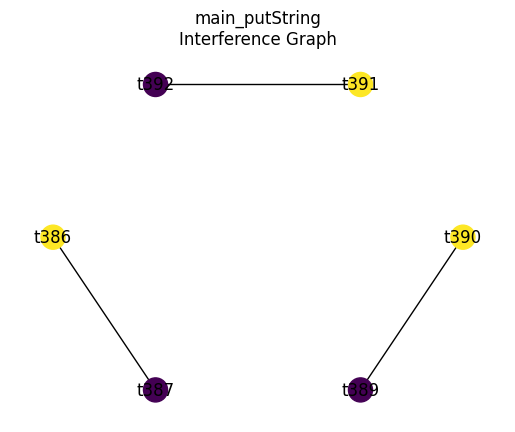

depth {'local_s.41': 8, 'local_i.42': 16}
>   store i64* %local_s.41.arg0, i64** %local_s.41, align 8
toR local_s.41.arg0
toR local_s.41
  - ['movq %rdi, -8(%rbp)']
>   %t380 = add i64 0, 0
toR i64 0
toR i64 0
toR t380
  - ['movq $0, %r8', 'addq $0, %r8']
>   store i64 %t380, i64* %local_i.42, align 4
toR t380
toR local_i.42
  - ['movq %r8, -16(%rbp)']
>   br label %for.cond20.381
  - []
>   %t386 = load i64, i64* %local_i.42, align 4
toR t386
toR local_i.42
  - ['movq -16(%rbp), %r9']
>   %t387 = load i64*, i64** %local_s.41, align 4
toR t387
toR local_s.41
  - ['movq -8(%rbp), %r8']
>   %t388 = getelementptr inbounds i64, i64* %t387, i64 %t386
toR t387
toR t386
toR t388
  - ['leaq (%r8,%r9,8), %r8']
>   %t389 = load i64, i64* %t388, align 4
toR t389
toR t388
  - ['movq (%r8), %r8']
>   %t390 = add i64 0, 0
toR i64 0
toR i64 0
toR t390
  - ['movq $0, %r9', 'addq $0, %r9']
>   %t385 = icmp ne i64 %t389, %t390
toR t389
toR t390
toR t385
  - ['pushq %rax', 'movq $0, %rax', 'cmpq %r9, %r8

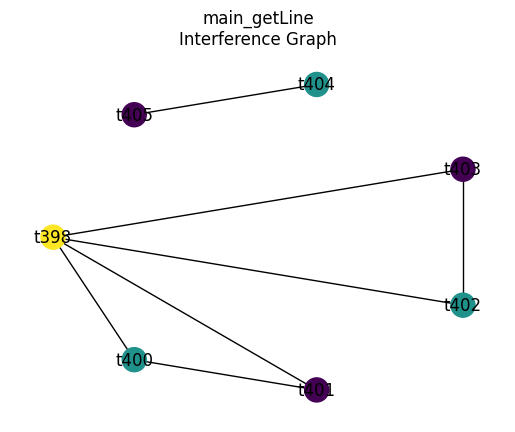

depth {'local_maxLen.43': 8, 'local_stop.44': 16}
>   store i64 %local_maxLen.43.arg0, i64* %local_maxLen.43, align 4
toR local_maxLen.43.arg0
toR local_maxLen.43
  - ['movq %rdi, -8(%rbp)']
>   %t399 = call noalias i8* @malloc(i64 16)
toR t399
toR i64 16
  - ['movq $16, %rdi', 'call malloc@PLT', 'movq %rax, %r8']
>   %t398 = bitcast i8* %t399 to i64*
toR t399
toR t398
  - ['movq %r8, %r10']
>   %t400 = add i64 0, 10
toR i64 0
toR i64 10
toR t400
  - ['movq $0, %r9', 'addq $10, %r9']
>   %t401 = getelementptr inbounds i64, i64* %t398, i64 0
toR t398
toR i64 0
toR t401
  - ['movq $0, %rax', 'leaq (%r10,%rax,8), %r8']
>   store i64 %t400, i64* %t401, align 4
toR t400
toR t401
  - ['movq %r9, (%r8)']
>   %t402 = add i64 0, 0
toR i64 0
toR i64 0
toR t402
  - ['movq $0, %r9', 'addq $0, %r9']
>   %t403 = getelementptr inbounds i64, i64* %t398, i64 1
toR t398
toR i64 1
toR t403
  - ['movq $1, %rax', 'leaq (%r10,%rax,8), %r8']
>   store i64 %t402, i64* %t403, align 4
toR t402
toR t403
  - ['mo

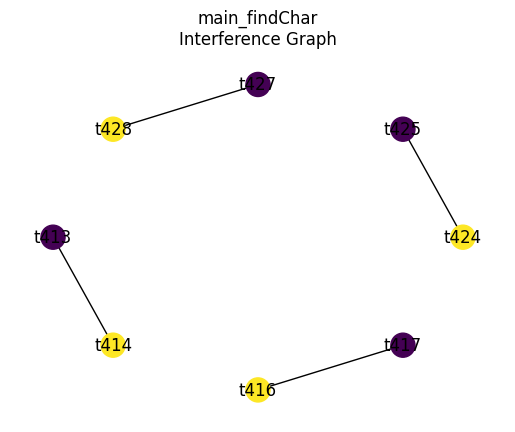

depth {'local_s.45': 8, 'local_c.46': 16, 'local_x.47': 24, 'local_i.48': 32}
>   store i64* %local_s.45.arg0, i64** %local_s.45, align 8
toR local_s.45.arg0
toR local_s.45
  - ['movq %rdi, -8(%rbp)']
>   store i64 %local_c.46.arg1, i64* %local_c.46, align 4
toR local_c.46.arg1
toR local_c.46
  - ['movq %rsi, -16(%rbp)']
>   store i64 %local_x.47.arg2, i64* %local_x.47, align 4
toR local_x.47.arg2
toR local_x.47
  - ['movq %rdx, -24(%rbp)']
>   %t407 = load i64, i64* %local_x.47, align 4
toR t407
toR local_x.47
  - ['movq -24(%rbp), %r8']
>   store i64 %t407, i64* %local_i.48, align 4
toR t407
toR local_i.48
  - ['movq %r8, -32(%rbp)']
>   br label %for.cond21.408
  - []
>   %t413 = load i64, i64* %local_i.48, align 4
toR t413
toR local_i.48
  - ['movq -32(%rbp), %r8']
>   %t414 = load i64*, i64** %local_s.45, align 4
toR t414
toR local_s.45
  - ['movq -8(%rbp), %r9']
>   %t415 = getelementptr inbounds i64, i64* %t414, i64 %t413
toR t414
toR t413
toR t415
  - ['leaq (%r9,%r8,8), %r8']


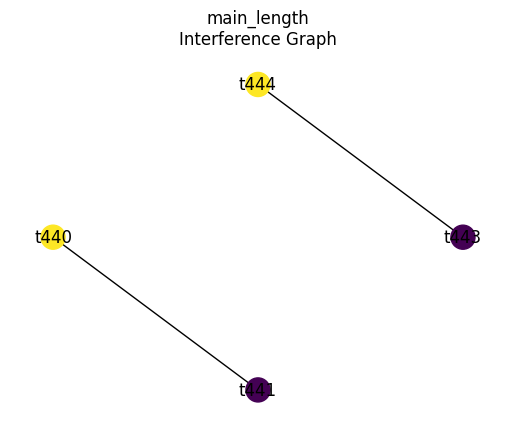

depth {'local_s.49': 8, 'local_i.50': 16}
>   store i64* %local_s.49.arg0, i64** %local_s.49, align 8
toR local_s.49.arg0
toR local_s.49
  - ['movq %rdi, -8(%rbp)']
>   %t434 = add i64 0, 0
toR i64 0
toR i64 0
toR t434
  - ['movq $0, %r8', 'addq $0, %r8']
>   store i64 %t434, i64* %local_i.50, align 4
toR t434
toR local_i.50
  - ['movq %r8, -16(%rbp)']
>   br label %for.cond23.435
  - []
>   %t440 = load i64, i64* %local_i.50, align 4
toR t440
toR local_i.50
  - ['movq -16(%rbp), %r9']
>   %t441 = load i64*, i64** %local_s.49, align 4
toR t441
toR local_s.49
  - ['movq -8(%rbp), %r8']
>   %t442 = getelementptr inbounds i64, i64* %t441, i64 %t440
toR t441
toR t440
toR t442
  - ['leaq (%r8,%r9,8), %r8']
>   %t443 = load i64, i64* %t442, align 4
toR t443
toR t442
  - ['movq (%r8), %r8']
>   %t444 = add i64 0, 0
toR i64 0
toR i64 0
toR t444
  - ['movq $0, %r9', 'addq $0, %r9']
>   %t439 = icmp ne i64 %t443, %t444
toR t443
toR t444
toR t439
  - ['pushq %rax', 'movq $0, %rax', 'cmpq %r9, %r8

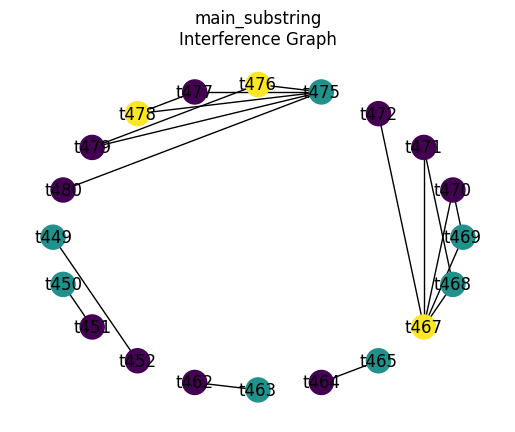

depth {'local_s.51': 8, 'local_start.52': 16, 'local_end.53': 24, 'local_sub.54': 32, 'local_i.55': 40}
>   store i64* %local_s.51.arg0, i64** %local_s.51, align 8
toR local_s.51.arg0
toR local_s.51
  - ['movq %rdi, -8(%rbp)']
>   store i64 %local_start.52.arg1, i64* %local_start.52, align 4
toR local_start.52.arg1
toR local_start.52
  - ['movq %rsi, -16(%rbp)']
>   store i64 %local_end.53.arg2, i64* %local_end.53, align 4
toR local_end.53.arg2
toR local_end.53
  - ['movq %rdx, -24(%rbp)']
>   %t450 = load i64, i64* %local_end.53, align 4
toR t450
toR local_end.53
  - ['movq -24(%rbp), %r9']
>   %t451 = load i64, i64* %local_start.52, align 4
toR t451
toR local_start.52
  - ['movq -16(%rbp), %r8']
>   %t449 = sub i64 %t450, %t451
toR t450
toR t451
toR t449
  - ['movq %r9, %r9', 'subq %r8, %r9']
>   %t452 = add i64 0, 1
toR i64 0
toR i64 1
toR t452
  - ['movq $0, %r8', 'addq $1, %r8']
>   %t448 = add i64 %t449, %t452
toR t449
toR t452
toR t448
  - ['movq %r8, %r8', 'addq %r9, %r8']
>   

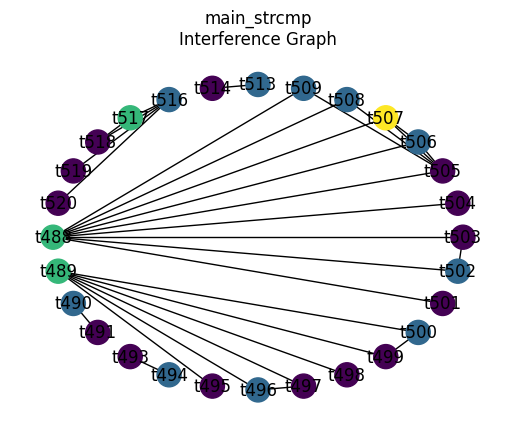

depth {'local_s1.56': 8, 'local_s2.57': 16, 'local_i.58': 24}
>   store i64* %local_s1.56.arg0, i64** %local_s1.56, align 8
toR local_s1.56.arg0
toR local_s1.56
  - ['movq %rdi, -8(%rbp)']
>   store i64* %local_s2.57.arg1, i64** %local_s2.57, align 8
toR local_s2.57.arg1
toR local_s2.57
  - ['movq %rsi, -16(%rbp)']
>   %t482 = add i64 0, 0
toR i64 0
toR i64 0
toR t482
  - ['movq $0, %r8', 'addq $0, %r8']
>   store i64 %t482, i64* %local_i.58, align 4
toR t482
toR local_i.58
  - ['movq %r8, -24(%rbp)']
>   br label %for.cond25.483
  - []
>   %t490 = load i64, i64* %local_i.58, align 4
toR t490
toR local_i.58
  - ['movq -24(%rbp), %r9']
>   %t491 = load i64*, i64** %local_s1.56, align 4
toR t491
toR local_s1.56
  - ['movq -8(%rbp), %r8']
>   %t492 = getelementptr inbounds i64, i64* %t491, i64 %t490
toR t491
toR t490
toR t492
  - ['leaq (%r8,%r9,8), %r8']
>   %t493 = load i64, i64* %t492, align 4
toR t493
toR t492
  - ['movq (%r8), %r8']
>   %t494 = add i64 0, 0
toR i64 0
toR i64 0
toR t4

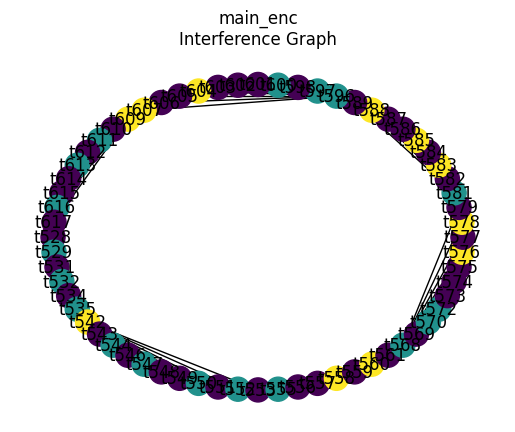

depth {'local_s.59': 8, 'local_res.60': 16, 'local_i.61': 24}
>   store i64* %local_s.59.arg0, i64** %local_s.59, align 8
toR local_s.59.arg0
toR local_s.59
  - ['movq %rdi, -8(%rbp)']
>   %t521 = add i64 0, 0
toR i64 0
toR i64 0
toR t521
  - ['movq $0, %r8', 'addq $0, %r8']
>   store i64 %t521, i64* %local_res.60, align 4
toR t521
toR local_res.60
  - ['movq %r8, -16(%rbp)']
>   %t522 = add i64 0, 0
toR i64 0
toR i64 0
toR t522
  - ['movq $0, %r8', 'addq $0, %r8']
>   store i64 %t522, i64* %local_i.61, align 4
toR t522
toR local_i.61
  - ['movq %r8, -24(%rbp)']
>   br label %for.cond26.523
  - []
>   %t528 = load i64, i64* %local_i.61, align 4
toR t528
toR local_i.61
  - ['movq -24(%rbp), %r8']
>   %t529 = load i64*, i64** %local_s.59, align 4
toR t529
toR local_s.59
  - ['movq -8(%rbp), %r9']
>   %t530 = getelementptr inbounds i64, i64* %t529, i64 %t528
toR t529
toR t528
toR t530
  - ['leaq (%r9,%r8,8), %r8']
>   %t531 = load i64, i64* %t530, align 4
toR t531
toR t530
  - ['movq (%r8

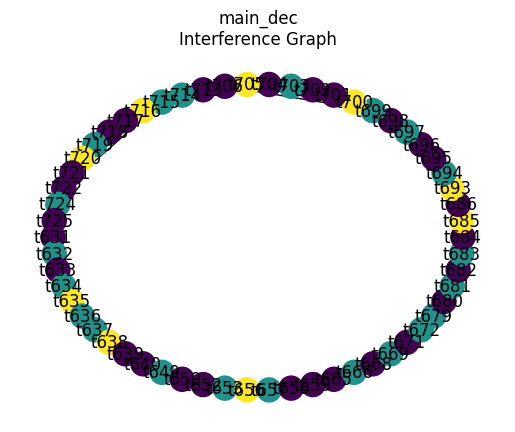

depth {'local_code.62': 8, 'local_res.63': 16, 'local_len.64': 24, 'local_tmp.65': 32, 'local_i.66': 40, 'local_mod.67': 48}
>   store i64 %local_code.62.arg0, i64* %local_code.62, align 4
toR local_code.62.arg0
toR local_code.62
  - ['movq %rdi, -8(%rbp)']
>   %t621 = add i64 0, 5
toR i64 0
toR i64 5
toR t621
  - ['movq $0, %r8', 'addq $5, %r8']
>   %t623 = mul i64 %t621, 8
toR t621
toR i64 8
toR t623
  - ['pushq %rax', 'pushq %rdx', 'pushq %rcx', 'movq %r8, %rax', 'movq $8, %rcx', 'imulq %rcx', 'movq %rax, %r8', 'popq %rcx', 'popq %rdx', 'popq %rax']
>   %t624 = call noalias i8* @malloc(i64 %t623)
toR t624
toR t623
  - ['movq %r8, %rdi', 'call malloc@PLT', 'movq %rax, %r8']
>   %t622 = bitcast i8* %t624 to i64*
toR t624
toR t622
  - ['movq %r8, %r8']
>   store i64* %t622, i64** %local_res.63, align 8
toR t622
toR local_res.63
  - ['movq %r8, -16(%rbp)']
>   %t631 = load i64, i64* %local_code.62, align 4
toR t631
toR local_code.62
  - ['movq -8(%rbp), %r8']
>   %t632 = add i64 0, 0
to

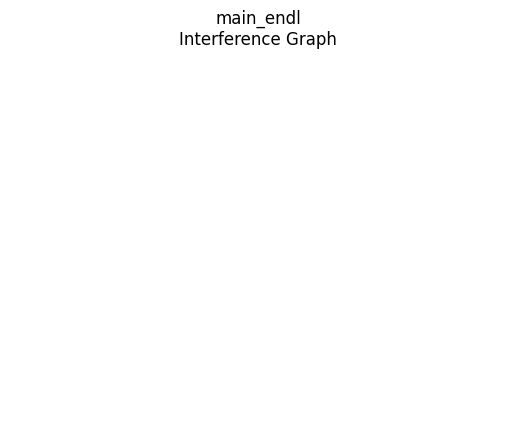

depth {}
>   %t729 = add i64 0, 10
toR i64 0
toR i64 10
toR t729
  - ['movq $0, %r8', 'addq $10, %r8']
>   %t730 = call i64 @putchar(i64 %t729)
toR t730
toR t729
  - ['movq %r8, %rdi', 'call putchar@PLT', 'movq %rax, %r8']
>   ret void
  - []
-- ASM: --
	.globl main_endl
	main_endl:
pushq %rbp
movq %rsp, %rbp
subq $0, %rsp
pushq %r8
pushq %r9
pushq %r10
pushq %r11
pushq %r12
pushq %r13
pushq %r14
pushq %r15
  #  %t729 = add i64 0, 10
movq $0, %r8
addq $10, %r8
  #  %t730 = call i64 @putchar(i64 %t729)
movq %r8, %rdi
call putchar@PLT
movq %rax, %r8
  #  ret void
	main_endl_end:
popq %r15
popq %r14
popq %r13
popq %r12
popq %r11
popq %r10
popq %r9
popq %r8
movq %rbp, %rsp
popq %rbp
retq
codeGenForFunc main_putSpace
{'for.cond36.731': 4, 'for.body36.733': 8, 'for.post36.732': 11, 'for.end36.734': 15}
  br label %for.cond36.731
  br i1 %t736, label %for.body36.733, label %for.end36.734
  br label %for.post36.732
  br label %for.cond36.731
0 [[1], {'local_n.68.arg0'}, set()]
1 [[2], set(), {

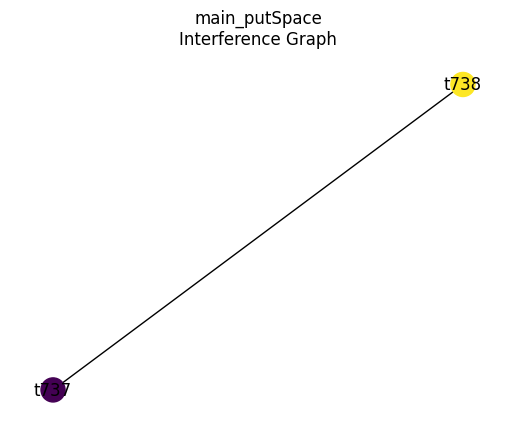

depth {'local_n.68': 8, 'local_i.69': 16}
>   store i64 %local_n.68.arg0, i64* %local_n.68, align 4
toR local_n.68.arg0
toR local_n.68
  - ['movq %rdi, -8(%rbp)']
>   %t735 = add i64 0, 0
toR i64 0
toR i64 0
toR t735
  - ['movq $0, %r8', 'addq $0, %r8']
>   store i64 %t735, i64* %local_i.69, align 4
toR t735
toR local_i.69
  - ['movq %r8, -16(%rbp)']
>   br label %for.cond36.731
  - []
>   %t737 = load i64, i64* %local_i.69, align 4
toR t737
toR local_i.69
  - ['movq -16(%rbp), %r8']
>   %t738 = load i64, i64* %local_n.68, align 4
toR t738
toR local_n.68
  - ['movq -8(%rbp), %r9']
>   %t736 = icmp slt i64 %t737, %t738
toR t737
toR t738
toR t736
  - ['pushq %rax', 'movq $0, %rax', 'cmpq %r9, %r8', 'setl %al', 'movq %rax, %r8', 'popq %rax']
>   br i1 %t736, label %for.body36.733, label %for.end36.734
toR t736
  - ['cmpq $0, %r8', 'je for.end36.734']
>   %t739 = add i64 0, 32
toR i64 0
toR i64 32
toR t739
  - ['movq $0, %r8', 'addq $32, %r8']
>   %t740 = call i64 @putchar(i64 %t739)
toR t

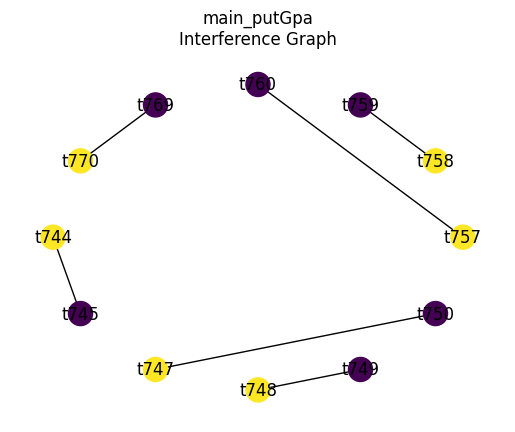

depth {'local_n.70': 8, 'local_integer.71': 16, 'local_d.72': 24}
>   store i64 %local_n.70.arg0, i64* %local_n.70, align 4
toR local_n.70.arg0
toR local_n.70
  - ['movq %rdi, -8(%rbp)']
>   %t744 = load i64, i64* %local_n.70, align 4
toR t744
toR local_n.70
  - ['movq -8(%rbp), %r9']
>   %t745 = add i64 0, 100
toR i64 0
toR i64 100
toR t745
  - ['movq $0, %r8', 'addq $100, %r8']
>   %t743 = sdiv i64 %t744, %t745
toR t744
toR t745
toR t743
  - ['pushq %rax', 'pushq %rdx', 'movq %r9, %rax', 'cqto', 'idivq %r8', 'movq %rax, %r8', 'popq %rdx', 'popq %rax']
>   store i64 %t743, i64* %local_integer.71, align 4
toR t743
toR local_integer.71
  - ['movq %r8, -16(%rbp)']
>   %t748 = load i64, i64* %local_n.70, align 4
toR t748
toR local_n.70
  - ['movq -8(%rbp), %r9']
>   %t749 = add i64 0, 100
toR i64 0
toR i64 100
toR t749
  - ['movq $0, %r8', 'addq $100, %r8']
>   %t747 = srem i64 %t748, %t749
toR t748
toR t749
toR t747
  - ['pushq %rax', 'pushq %rdx', 'movq %r9, %rax', 'cqto', 'idivq %r8', 

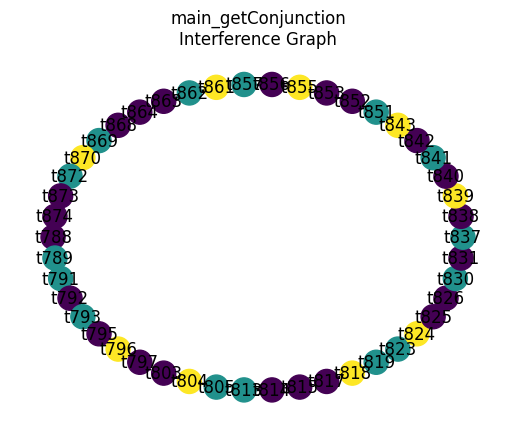

depth {'local_s.73': 8, 'local_ret.74': 16, 'local_idx.75': 24, 'local_total.76': 32, 'local_start.77': 40, 'local_end.78': 48, 'local_sub.79': 56, 'local_res.80': 64, 'local_end.81': 72, 'local_sub.82': 80, 'local_res.83': 88}
>   store i64* %local_s.73.arg0, i64** %local_s.73, align 8
toR local_s.73.arg0
toR local_s.73
  - ['movq %rdi, -8(%rbp)']
>   %t778 = add i64 0, 10
toR i64 0
toR i64 10
toR t778
  - ['movq $0, %r8', 'addq $10, %r8']
>   %t780 = mul i64 %t778, 8
toR t778
toR i64 8
toR t780
  - ['pushq %rax', 'pushq %rdx', 'pushq %rcx', 'movq %r8, %rax', 'movq $8, %rcx', 'imulq %rcx', 'movq %rax, %r8', 'popq %rcx', 'popq %rdx', 'popq %rax']
>   %t781 = call noalias i8* @malloc(i64 %t780)
toR t781
toR t780
  - ['movq %r8, %rdi', 'call malloc@PLT', 'movq %rax, %r8']
>   %t779 = bitcast i8* %t781 to i64*
toR t781
toR t779
  - ['movq %r8, %r8']
>   store i64* %t779, i64** %local_ret.74, align 8
toR t779
toR local_ret.74
  - ['movq %r8, -16(%rbp)']
>   %t788 = add i64 0, 0
toR i64 0
t

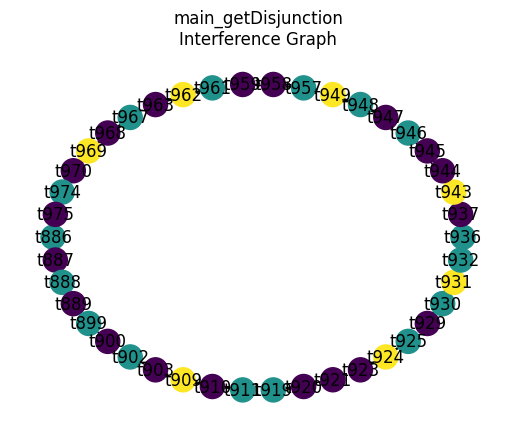

depth {'local_s.84': 8, 'local_ret.85': 16, 'local_i.86': 24, 'local_idx.87': 32, 'local_total.88': 40, 'local_start.89': 48, 'local_end.90': 56, 'local_sub.91': 64, 'local_res.92': 72, 'local_end.93': 80, 'local_sub.94': 88, 'local_res.95': 96}
>   store i64* %local_s.84.arg0, i64** %local_s.84, align 8
toR local_s.84.arg0
toR local_s.84
  - ['movq %rdi, -8(%rbp)']
>   %t876 = add i64 0, 10
toR i64 0
toR i64 10
toR t876
  - ['movq $0, %r8', 'addq $10, %r8']
>   %t878 = mul i64 %t876, 8
toR t876
toR i64 8
toR t878
  - ['pushq %rax', 'pushq %rdx', 'pushq %rcx', 'movq %r8, %rax', 'movq $8, %rcx', 'imulq %rcx', 'movq %rax, %r8', 'popq %rcx', 'popq %rdx', 'popq %rax']
>   %t879 = call noalias i8* @malloc(i64 %t878)
toR t879
toR t878
  - ['movq %r8, %rdi', 'call malloc@PLT', 'movq %rax, %r8']
>   %t877 = bitcast i8* %t879 to i64**
toR t879
toR t877
  - ['movq %r8, %r8']
>   store i64** %t877, i64*** %local_ret.85, align 8
toR t877
toR local_ret.85
  - ['movq %r8, -16(%rbp)']
>   %t884 = add

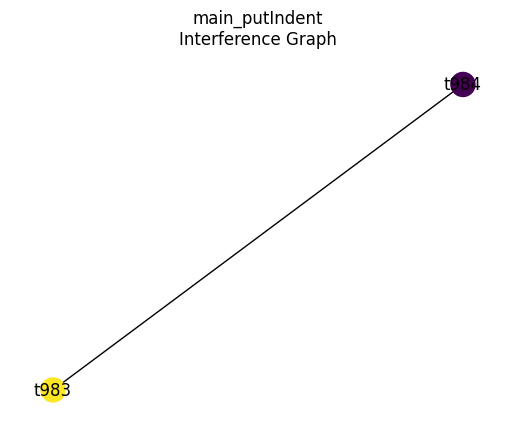

depth {'local_indent.96': 8, 'local_i.97': 16}
>   store i64 %local_indent.96.arg0, i64* %local_indent.96, align 4
toR local_indent.96.arg0
toR local_indent.96
  - ['movq %rdi, -8(%rbp)']
>   %t981 = add i64 0, 0
toR i64 0
toR i64 0
toR t981
  - ['movq $0, %r8', 'addq $0, %r8']
>   store i64 %t981, i64* %local_i.97, align 4
toR t981
toR local_i.97
  - ['movq %r8, -16(%rbp)']
>   br label %for.cond48.977
  - []
>   %t983 = load i64, i64* %local_i.97, align 4
toR t983
toR local_i.97
  - ['movq -16(%rbp), %r9']
>   %t984 = load i64, i64* %local_indent.96, align 4
toR t984
toR local_indent.96
  - ['movq -8(%rbp), %r8']
>   %t982 = icmp slt i64 %t983, %t984
toR t983
toR t984
toR t982
  - ['pushq %rax', 'movq $0, %rax', 'cmpq %r8, %r9', 'setl %al', 'movq %rax, %r8', 'popq %rax']
>   br i1 %t982, label %for.body48.979, label %for.end48.980
toR t982
  - ['cmpq $0, %r8', 'je for.end48.980']
>   %t985 = add i64 0, 4
toR i64 0
toR i64 4
toR t985
  - ['movq $0, %r8', 'addq $4, %r8']
>   call void 

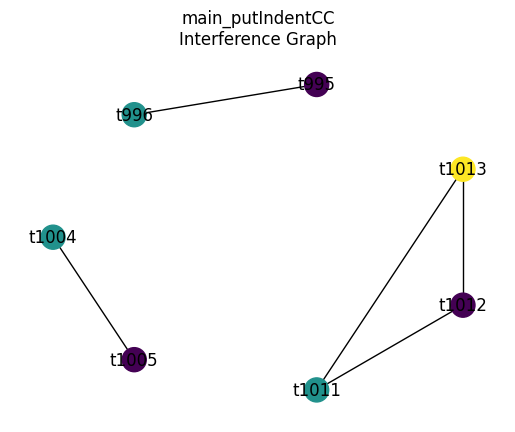

depth {'local_ind.98': 8, 'local_x.99': 16, 'local_c1.100': 24, 'local_c2.101': 32, 'local_debug.102': 40}
>   store i64 %local_ind.98.arg0, i64* %local_ind.98, align 4
toR local_ind.98.arg0
toR local_ind.98
  - ['movq %rdi, -8(%rbp)']
>   store i64 %local_x.99.arg1, i64* %local_x.99, align 4
toR local_x.99.arg1
toR local_x.99
  - ['movq %rsi, -16(%rbp)']
>   store i64 %local_c1.100.arg2, i64* %local_c1.100, align 4
toR local_c1.100.arg2
toR local_c1.100
  - ['movq %rdx, -24(%rbp)']
>   store i64 %local_c2.101.arg3, i64* %local_c2.101, align 4
toR local_c2.101.arg3
toR local_c2.101
  - ['movq %rcx, -32(%rbp)']
>   %t988 = add i64 0, 0
toR i64 0
toR i64 0
toR t988
  - ['movq $0, %r8', 'addq $0, %r8']
>   store i64 %t988, i64* %local_debug.102, align 4
toR t988
toR local_debug.102
  - ['movq %r8, -40(%rbp)']
>   %t995 = load i64, i64* %local_debug.102, align 4
toR t995
toR local_debug.102
  - ['movq -40(%rbp), %r8']
>   %t996 = add i64 0, 1
toR i64 0
toR i64 1
toR t996
  - ['movq $0, %r9

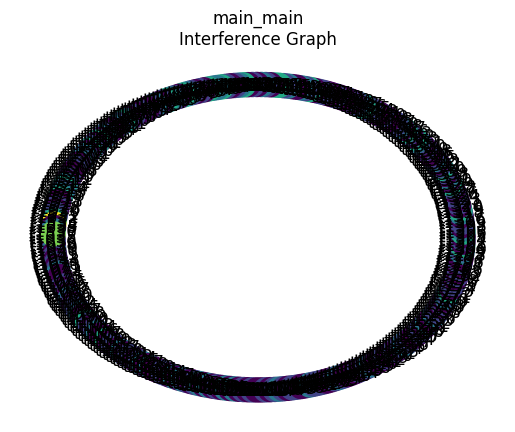

depth {'local_gpa.103': 8, 'local_ha.104': 16, 'local_hc.105': 24, 'local_cr.106': 32, 'local_possible.107': 40, 'local_possibleNum.108': 48, 'local_lines.109': 56, 'local_lineNum.110': 64, 'local_line.111': 72, 'local_ids.112': 80, 'local_logics.113': 88, 'local_creds.114': 96, 'local_scores.115': 104, 'local_i.116': 112, 'local_i.117': 120, 'local_div1.118': 128, 'local_div2.119': 136, 'local_div3.120': 144, 'local_len.121': 152, 'local_part1.122': 160, 'local_part2.123': 168, 'local_part3.124': 176, 'local_part4.125': 184, 'local_id.126': 192, 'local_cred.127': 200, 'local_logic.128': 208, 'local_idx.129': 216, 'local_curId.130': 224, 'local_curCred.131': 232, 'local_curScore.132': 240, 'local_curLogic.133': 248, 'local_ii.134': 256, 'local_boolDisj.135': 264, 'local_boolConj.136': 272, 'local_jj.137': 280, 'local_id2.138': 288, 'local_score2.139': 296}
>   %t1014 = add i64 0, 0
toR i64 0
toR i64 0
toR t1014
  - ['movq $0, %r8', 'addq $0, %r8']
>   store i64 %t1014, i64* %local_gpa.

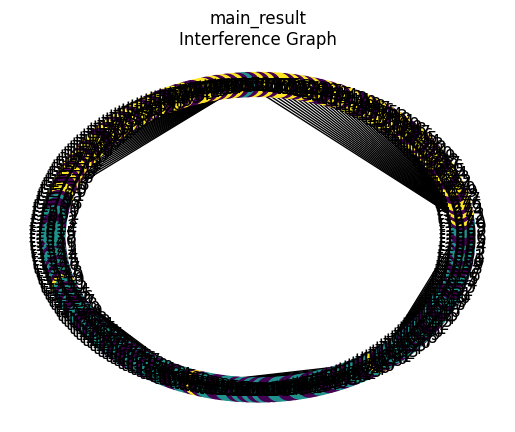

depth {'local_gpa.140': 8, 'local_ha.141': 16, 'local_hc.142': 24, 'local_cr.143': 32, 'local_possible.144': 40, 'local_possibleNum.145': 48, 'local_sGpa.146': 56, 'local_sHoursAttempted.147': 64, 'local_sHoursCompleted.148': 72, 'local_sCreditsRemaining.149': 80, 'local_sPossibleCourses.150': 88, 'local_sNone.151': 96, 'local_i.152': 104}
>   store i64 %local_gpa.140.arg0, i64* %local_gpa.140, align 4
toR local_gpa.140.arg0
toR local_gpa.140
  - ['movq %rdi, -8(%rbp)']
>   store i64 %local_ha.141.arg1, i64* %local_ha.141, align 4
toR local_ha.141.arg1
toR local_ha.141
  - ['movq %rsi, -16(%rbp)']
>   store i64 %local_hc.142.arg2, i64* %local_hc.142, align 4
toR local_hc.142.arg2
toR local_hc.142
  - ['movq %rdx, -24(%rbp)']
>   store i64 %local_cr.143.arg3, i64* %local_cr.143, align 4
toR local_cr.143.arg3
toR local_cr.143
  - ['movq %rcx, -32(%rbp)']
>   store i64* %local_possible.144.arg4, i64** %local_possible.144, align 8
toR local_possible.144.arg4
toR local_possible.144
  - []
>

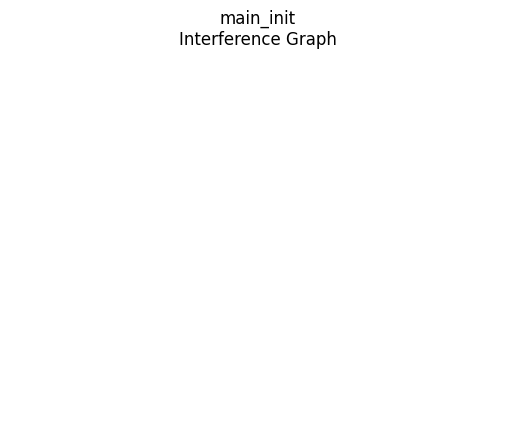

depth {}
>   ret void
  - []
-- ASM: --
	.globl main_init
	main_init:
pushq %rbp
movq %rsp, %rbp
subq $0, %rsp
pushq %r8
pushq %r9
pushq %r10
pushq %r11
pushq %r12
pushq %r13
pushq %r14
pushq %r15
  #  ret void
	main_init_end:
popq %r15
popq %r14
popq %r13
popq %r12
popq %r11
popq %r10
popq %r9
popq %r8
movq %rbp, %rsp
popq %rbp
retq
codeGenForFunc main
{}
0 [[1], set(), set()]
1 [[2], set(), set()]
2 [[], set(), set()]
done
count 1
0 {} {} | {} {}
1 {} {} | {} {}
2 {} {} | {} {}
{}
0
set()
coloring {}
single nodes: set()
color needed: 0


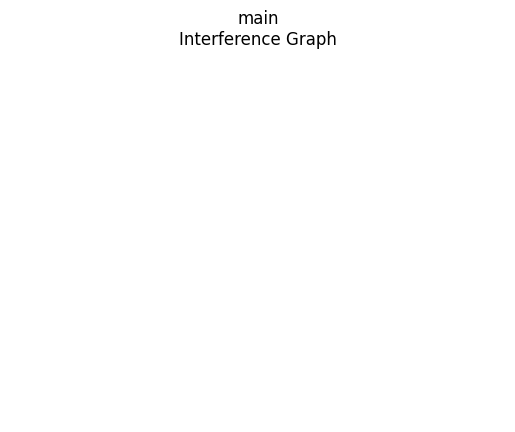

depth {}
>   call void @main_init()
  - ['call main_init@PLT']
>   call void @main_main()
  - ['call main_main@PLT']
>   ret i64 0
toR i64 0
  - ['movq $0, %rax', 'jmp main_end']
-- ASM: --
	.globl main
	main:
pushq %rbp
movq %rsp, %rbp
subq $0, %rsp
pushq %r8
pushq %r9
pushq %r10
pushq %r11
pushq %r12
pushq %r13
pushq %r14
pushq %r15
  #  call void @main_init()
call main_init@PLT
  #  call void @main_main()
call main_main@PLT
  #  ret i64 0
movq $0, %rax
jmp main_end
	main_end:
popq %r15
popq %r14
popq %r13
popq %r12
popq %r11
popq %r10
popq %r9
popq %r8
movq %rbp, %rsp
popq %rbp
retq


In [38]:
# ll2asm('../build/fib.debug.ll', 'fib.s')
# ll2asm('../build/make.ll', 'make.s')
# ll2asm('../build/sort.ll', 'sort.s')
# ll2asm('../build/manyArg.debug.ll', 'test.s')
# ll2asm('../build/matrix.o.ll', 'test.s')
# ll2asm('../build/course_selection.o.ll', 'test.s')

parser = argparse.ArgumentParser(description="The Backend of the Compiler")

parser.add_argument('-f', '--file', type=str, help="Input file name")
parser.add_argument('-o', '--output', type=str, help="Output file name")

args = parser.parse_args()

input_file = args.file
output_file = args.output

ll2asm(input_file, output_file)